In [1]:
import pickle
from pathlib import Path
from easydict import EasyDict
import pandas as pd
from matplotlib import pyplot as plt
from ml import train
from dataloading import get_data, build_features, DataParser, MovingWindow
from tabulate import tabulate
from IPython.display import clear_output
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score

%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
def smooth_bin_labels(y, dp=0.3):
    y = y.astype(np.float32)
    d = np.random.uniform(0, dp, sum(y[:, 0]==0))
    y[y[:, 0]==0, 0] = d
    y[y[:, 1]==1, 1] = 1-d
    return y

def smooth_prob_labels(y, dp=0.1):
    y = y.astype(float)
    d = np.random.uniform(-dp, dp, sum(y[:, 0]==0))
    y += dp
    return y

def stohastic_prediction(input_tensor):
    pmeans, pstds, ymeans = np.zeros((3, input_tensor.shape[0]))
    for i, x in enumerate(input_tensor):
        p = model(torch.stack([x]*7)).detach().cpu().numpy()[:, 0]
        pmeans[i] = np.median(p)
        pstds[i] = p.std()
    pmeans = pmeans*(pstds<0.1)
    return pmeans, pstds

def calc_weights(predicts, th):
    p = (predicts > th).astype(np.float32)
    return p
    #return np.clip((predicts+th)**30, 0, 1)
    
def calc_weights2(predicts, th):
    p = (predicts>th).sum(axis=0)/predicts.shape[0] >= 0.2
    #p = np.median(predicts, axis=0) > th
    return p

In [28]:
from dataloading import collect_train_data
X, y = collect_train_data("./optimization/", 64)

24


Load pickles: 100%|██████████| 24/24 [00:09<00:00,  2.50it/s]

(7261, 1, 8, 64) (7261,)
20170818 -> 20201023


test dates: 20220727:20231127:   0%|          | 0/414 [00:00<?, ?it/s]

test dates: 20220727:20231127: 100%|██████████| 414/414 [00:00<00:00, 25572.39it/s]


001 loss train: 1672.7174 | test: 2352.4634   ROC train: 0.5652 | test: 0.5168
002 loss train: 1661.3476 | test: 2744.7000   ROC train: 0.5705 | test: 0.5177
003 loss train: 1650.5728 | test: 2659.8547   ROC train: 0.5826 | test: 0.5288
004 loss train: 1648.6929 | test: 2788.0518   ROC train: 0.5834 | test: 0.5338
005 loss train: 1645.0295 | test: 2454.4675   ROC train: 0.5874 | test: 0.5383
006 loss train: 1649.1730 | test: 3020.9436   ROC train: 0.5898 | test: 0.5276
007 loss train: 1653.3156 | test: 2593.7026   ROC train: 0.5871 | test: 0.5300
008 loss train: 1642.0762 | test: 2750.2227   ROC train: 0.5894 | test: 0.5284
009 loss train: 1638.7742 | test: 2750.9683   ROC train: 0.5911 | test: 0.5263
010 loss train: 1637.9010 | test: 2633.7209   ROC train: 0.5918 | test: 0.5249
011 loss train: 1635.2297 | test: 2680.8760   ROC train: 0.5962 | test: 0.5274
012 loss train: 1632.3207 | test: 2657.1343   ROC train: 0.5984 | test: 0.5235
013 loss train: 1638.1167 | test: 2454.7495   ROC tr

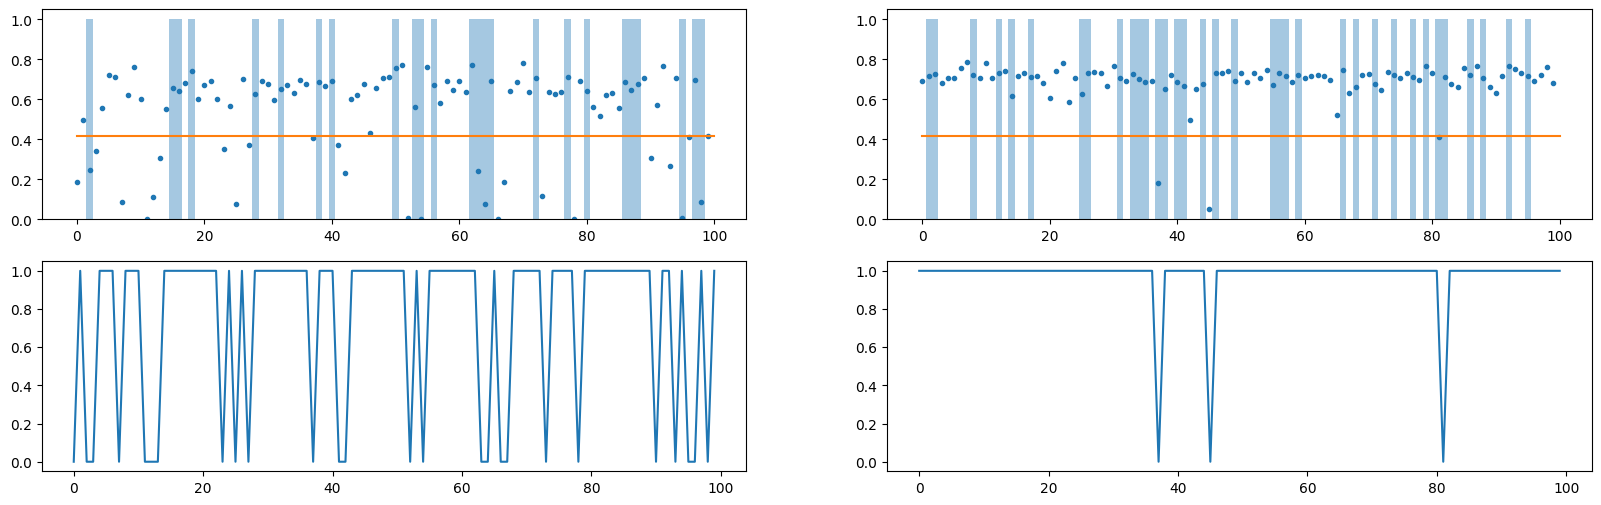

In [31]:
import torch
device = "cuda"

nitrers = 10
test_split_size = 0.2
calc_test = True

pprofits, gprofits, metrics, table = np.zeros((3, nitrers)), np.zeros((3, nitrers)), np.zeros((2, nitrers)), []
for i in range(1):#int(1/test_split_size)):
    if i >= 0:
        np.random.seed(i)
        X_train, X_test, y_train, y_test, profs_train, profs_test, tf_test, _ = get_data(X, y, test_split_size, 4, 5)
    X_train = torch.tensor(X_train).float().to(device)
    X_test = torch.tensor(X_test).float().to(device)
    model = train(X_train, y_train, X_test, y_test, batch_size=1024, epochs=30, device=device, calc_test=calc_test)
    model.eval()
    p_test = model(X_test).detach().cpu().numpy().squeeze()[:, 0]
    p_train = model(X_train).detach().cpu().numpy().squeeze()[:, 0]    
    # p_test, _ = stohastic_prediction(X_test)
    # p_train, _ = stohastic_prediction(X_train) 
    
    p_test = np.expand_dims(p_test, 0)
    # for m in range(3):
    #     np.random.seed(m+100)
    #     train_ids = np.random.choice(np.arange(y_train.shape[0]), int(y_train.shape[0]*0.7))
    #     model = train(X_train[train_ids], y_train[train_ids], X_test, y_test, batch_size=512, device=device, calc_test=False)
    #     model.eval()
    #     p_test_ = model(X_test).detach().cpu().numpy().squeeze()[:, 0]
    #     p_test = np.vstack([p_test, p_test_])
    # p_test = np.median(p_test, 0).squeeze()
        
    roc_train = roc_auc_score(y_train, p_train.reshape(-1, 1))
    roc_test = roc_auc_score(y_test, p_test.reshape(-1, 1))
    profsum_best, threshold = -999999, np.percentile(p_train, 20)
    # for th in np.arange(0., 0.9, 0.025):
    #     profsum = f1_score(y_train[:, 0], p_train>th)
    #     if profsum > profsum_best:
    #         profsum_best = profsum
    #         threshold = th

    w_profs_train = calc_weights(p_train, threshold)
    
    if test_split_size > 0:
        w_profs_test = calc_weights(p_test[0], threshold)
        for j in range(3):
            ids = tf_test == j
            pprofits[j, i] = (profs_test[ids]*w_profs_test[ids]).sum()
            gprofits[j, i] = profs_test[ids].sum()
        
        pprofs_sum = np.nansum(pprofits[:, :i+1], 0) 
        gprofs_sum = np.nansum(gprofits[:, :i+1], 0)
        profs_ratio = (pprofs_sum - gprofs_sum)/abs(gprofs_sum)*100
        curprof_ratio = (pprofs_sum[-1] - gprofs_sum[-1])/abs(gprofs_sum[-1])*100
        model_fails = np.nansum(profs_ratio < 0)/(i+1)
        prof_boost_mean = np.nanmean(profs_ratio)
        prof_boost_median = np.nanmedian(profs_ratio)
        prof_boost_std = np.nanstd(profs_ratio)
        if i > 0:
            clear_output(wait=True)
        table.append([i, roc_train, roc_test, pprofs_sum[-1], gprofs_sum[-1], curprof_ratio, 
                      prof_boost_mean, prof_boost_median, prof_boost_std, model_fails*100, profsum_best, threshold])
        print(tabulate(table, headers=["iter", "ROC train", "ROC test", "prof", "gprof", "pboost", "pboost mean", "pboost median", "pboost std", "model_fails, %", "f1 best", "threshold"]))
        print()
        
plt.figure(figsize=(20, 6))
plt.subplot(2, 2, 1)
plt.plot(p_train[:100], ".")
plt.bar(np.arange(100), y_train[:100, 0], width=[1]*100, alpha=0.4)
plt.plot([0, 100], [threshold, threshold])
if len(p_test):
    p_test4show = np.median(p_test, axis=0)
    plt.subplot(2, 2, 2)
    plt.plot(p_test4show[:100], ".")
    plt.bar(np.arange(100), y_test[:100, 0], width=[1]*100, alpha=0.4)
    # plt.bar(np.arange(100), profs_test[:100], width=[1]*100, alpha=0.2)
    plt.plot([0, 100], [threshold, threshold])
    plt.subplot(2, 2, 3)
    plt.plot(w_profs_train[:100])
    plt.subplot(2, 2, 4)
    plt.plot(w_profs_test[:100])
    # plt.plot(profs_test[:100]*w_profs_test[:100])
    # plt.plot(profs_test[:100], linewidth=3, alpha=0.5)  
    
    
model.set_threshold(threshold)
torch.save(model.state_dict(), "model.pth")

test dates: 20170818:20181107:   0%|          | 0/414 [00:00<?, ?it/s]

100%|██████████| 42441/42441 [00:00<00:00, 63032.14it/s]
2023-12-29 15:53:20.857 | INFO     | backtest:backtest:68 - ----------------------------------------
2023-12-29 15:53:20.858 | INFO     | backtest:backtest:70 -                           total backtest: 0.7 sec
2023-12-29 15:53:20.858 | INFO     | backtest:backtest:71 -                           expert updates:  69 %
2023-12-29 15:53:20.858 | INFO     | backtest:backtest:72 -                           broker updates:   8 %
2023-12-29 15:53:20.858 | INFO     | backtest:backtest:73 -                            data loadings:  20 %


167.7564078283409 0.37340545654296875


100%|██████████| 45453/45453 [00:00<00:00, 83063.69it/s]
2023-12-29 15:53:22.621 | INFO     | backtest:backtest:68 - ----------------------------------------
2023-12-29 15:53:22.622 | INFO     | backtest:backtest:70 -                           total backtest: 0.5 sec
2023-12-29 15:53:22.622 | INFO     | backtest:backtest:71 -                           expert updates:  57 %
2023-12-29 15:53:22.622 | INFO     | backtest:backtest:72 -                           broker updates:  12 %
2023-12-29 15:53:22.622 | INFO     | backtest:backtest:73 -                            data loadings:  26 %


140.34273660040836 0.39272371530532846


100%|██████████| 41591/41591 [00:00<00:00, 69371.68it/s]
2023-12-29 15:53:24.429 | INFO     | backtest:backtest:68 - ----------------------------------------
2023-12-29 15:53:24.429 | INFO     | backtest:backtest:70 -                           total backtest: 0.6 sec
2023-12-29 15:53:24.429 | INFO     | backtest:backtest:71 -                           expert updates:  63 %
2023-12-29 15:53:24.430 | INFO     | backtest:backtest:72 -                           broker updates:  11 %
2023-12-29 15:53:24.430 | INFO     | backtest:backtest:73 -                            data loadings:  23 %


119.52433229252532 0.23503143787384034


100%|██████████| 42435/42435 [00:00<00:00, 65622.84it/s]
2023-12-29 15:53:26.381 | INFO     | backtest:backtest:68 - ----------------------------------------
2023-12-29 15:53:26.381 | INFO     | backtest:backtest:70 -                           total backtest: 0.6 sec
2023-12-29 15:53:26.381 | INFO     | backtest:backtest:71 -                           expert updates:  66 %
2023-12-29 15:53:26.382 | INFO     | backtest:backtest:72 -                           broker updates:  10 %
2023-12-29 15:53:26.382 | INFO     | backtest:backtest:73 -                            data loadings:  20 %


-16.538296862993768 0.2783879518508911


100%|██████████| 46743/46743 [00:00<00:00, 90547.75it/s]
2023-12-29 15:53:28.167 | INFO     | backtest:backtest:68 - ----------------------------------------
2023-12-29 15:53:28.167 | INFO     | backtest:backtest:70 -                           total backtest: 0.5 sec
2023-12-29 15:53:28.167 | INFO     | backtest:backtest:71 -                           expert updates:  52 %
2023-12-29 15:53:28.167 | INFO     | backtest:backtest:72 -                           broker updates:  14 %
2023-12-29 15:53:28.167 | INFO     | backtest:backtest:73 -                            data loadings:  29 %


53.3949954369131 0.11981035619974137


100%|██████████| 42441/42441 [00:00<00:00, 59981.82it/s]
2023-12-29 15:53:30.073 | INFO     | backtest:backtest:68 - ----------------------------------------
2023-12-29 15:53:30.073 | INFO     | backtest:backtest:70 -                           total backtest: 0.7 sec
2023-12-29 15:53:30.073 | INFO     | backtest:backtest:71 -                           expert updates:  69 %
2023-12-29 15:53:30.073 | INFO     | backtest:backtest:72 -                           broker updates:   8 %
2023-12-29 15:53:30.073 | INFO     | backtest:backtest:73 -                            data loadings:  19 %


166.55742368245677 0.5159631371498108


100%|██████████| 45453/45453 [00:00<00:00, 85901.74it/s]
2023-12-29 15:53:31.818 | INFO     | backtest:backtest:68 - ----------------------------------------
2023-12-29 15:53:31.818 | INFO     | backtest:backtest:70 -                           total backtest: 0.5 sec
2023-12-29 15:53:31.819 | INFO     | backtest:backtest:71 -                           expert updates:  57 %
2023-12-29 15:53:31.819 | INFO     | backtest:backtest:72 -                           broker updates:  12 %
2023-12-29 15:53:31.819 | INFO     | backtest:backtest:73 -                            data loadings:  26 %


139.88680316232018 0.3415816128253937


100%|██████████| 41591/41591 [00:00<00:00, 68604.73it/s]
2023-12-29 15:53:33.648 | INFO     | backtest:backtest:68 - ----------------------------------------
2023-12-29 15:53:33.648 | INFO     | backtest:backtest:70 -                           total backtest: 0.6 sec
2023-12-29 15:53:33.648 | INFO     | backtest:backtest:71 -                           expert updates:  63 %
2023-12-29 15:53:33.648 | INFO     | backtest:backtest:72 -                           broker updates:  11 %
2023-12-29 15:53:33.648 | INFO     | backtest:backtest:73 -                            data loadings:  22 %


104.77935178565502 0.5543622136116028


100%|██████████| 42435/42435 [00:00<00:00, 67703.13it/s]
2023-12-29 15:53:35.568 | INFO     | backtest:backtest:68 - ----------------------------------------
2023-12-29 15:53:35.569 | INFO     | backtest:backtest:70 -                           total backtest: 0.6 sec
2023-12-29 15:53:35.569 | INFO     | backtest:backtest:71 -                           expert updates:  64 %
2023-12-29 15:53:35.570 | INFO     | backtest:backtest:72 -                           broker updates:  11 %
2023-12-29 15:53:35.570 | INFO     | backtest:backtest:73 -                            data loadings:  22 %


28.269394071197972 0.35607099533081055


100%|██████████| 46743/46743 [00:00<00:00, 91547.62it/s]
2023-12-29 15:53:37.350 | INFO     | backtest:backtest:68 - ----------------------------------------
2023-12-29 15:53:37.350 | INFO     | backtest:backtest:70 -                           total backtest: 0.5 sec
2023-12-29 15:53:37.350 | INFO     | backtest:backtest:71 -                           expert updates:  52 %
2023-12-29 15:53:37.351 | INFO     | backtest:backtest:72 -                           broker updates:  14 %
2023-12-29 15:53:37.351 | INFO     | backtest:backtest:73 -                            data loadings:  29 %


54.62369347746131 0.27184526324272157


100%|██████████| 42441/42441 [00:00<00:00, 62122.32it/s]
2023-12-29 15:53:39.236 | INFO     | backtest:backtest:68 - ----------------------------------------
2023-12-29 15:53:39.237 | INFO     | backtest:backtest:70 -                           total backtest: 0.7 sec
2023-12-29 15:53:39.237 | INFO     | backtest:backtest:71 -                           expert updates:  67 %
2023-12-29 15:53:39.237 | INFO     | backtest:backtest:72 -                           broker updates:   9 %
2023-12-29 15:53:39.237 | INFO     | backtest:backtest:73 -                            data loadings:  21 %


196.22640705544808 0.051951825618743896


100%|██████████| 45453/45453 [00:00<00:00, 86034.90it/s]
2023-12-29 15:53:40.987 | INFO     | backtest:backtest:68 - ----------------------------------------
2023-12-29 15:53:40.987 | INFO     | backtest:backtest:70 -                           total backtest: 0.5 sec
2023-12-29 15:53:40.987 | INFO     | backtest:backtest:71 -                           expert updates:  56 %
2023-12-29 15:53:40.987 | INFO     | backtest:backtest:72 -                           broker updates:  13 %
2023-12-29 15:53:40.988 | INFO     | backtest:backtest:73 -                            data loadings:  27 %


149.69263406436397 0.3259934723377228


100%|██████████| 41591/41591 [00:00<00:00, 69332.28it/s]
2023-12-29 15:53:42.826 | INFO     | backtest:backtest:68 - ----------------------------------------
2023-12-29 15:53:42.826 | INFO     | backtest:backtest:70 -                           total backtest: 0.6 sec
2023-12-29 15:53:42.826 | INFO     | backtest:backtest:71 -                           expert updates:  63 %
2023-12-29 15:53:42.827 | INFO     | backtest:backtest:72 -                           broker updates:  11 %
2023-12-29 15:53:42.827 | INFO     | backtest:backtest:73 -                            data loadings:  22 %


95.48735516896119 0.13857798278331757


100%|██████████| 42435/42435 [00:00<00:00, 65023.89it/s]
2023-12-29 15:53:44.787 | INFO     | backtest:backtest:68 - ----------------------------------------
2023-12-29 15:53:44.787 | INFO     | backtest:backtest:70 -                           total backtest: 0.7 sec
2023-12-29 15:53:44.787 | INFO     | backtest:backtest:71 -                           expert updates:  64 %
2023-12-29 15:53:44.787 | INFO     | backtest:backtest:72 -                           broker updates:  11 %
2023-12-29 15:53:44.787 | INFO     | backtest:backtest:73 -                            data loadings:  22 %


24.020466800002787 0.5113520741462707


100%|██████████| 46743/46743 [00:00<00:00, 87240.19it/s]
2023-12-29 15:53:46.674 | INFO     | backtest:backtest:68 - ----------------------------------------
2023-12-29 15:53:46.674 | INFO     | backtest:backtest:70 -                           total backtest: 0.5 sec
2023-12-29 15:53:46.675 | INFO     | backtest:backtest:71 -                           expert updates:  52 %
2023-12-29 15:53:46.675 | INFO     | backtest:backtest:72 -                           broker updates:  14 %
2023-12-29 15:53:46.675 | INFO     | backtest:backtest:73 -                            data loadings:  29 %


58.51701690473449 0.3225520014762878


100%|██████████| 42441/42441 [00:00<00:00, 54305.44it/s]
2023-12-29 15:53:48.608 | INFO     | backtest:backtest:68 - ----------------------------------------
2023-12-29 15:53:48.609 | INFO     | backtest:backtest:70 -                           total backtest: 0.8 sec
2023-12-29 15:53:48.609 | INFO     | backtest:backtest:71 -                           expert updates:  71 %
2023-12-29 15:53:48.609 | INFO     | backtest:backtest:72 -                           broker updates:   7 %
2023-12-29 15:53:48.609 | INFO     | backtest:backtest:73 -                            data loadings:  18 %


150.21298652163813 0.4779985249042511


100%|██████████| 45453/45453 [00:00<00:00, 86112.86it/s]
2023-12-29 15:53:50.386 | INFO     | backtest:backtest:68 - ----------------------------------------
2023-12-29 15:53:50.386 | INFO     | backtest:backtest:70 -                           total backtest: 0.5 sec
2023-12-29 15:53:50.386 | INFO     | backtest:backtest:71 -                           expert updates:  56 %
2023-12-29 15:53:50.387 | INFO     | backtest:backtest:72 -                           broker updates:  13 %
2023-12-29 15:53:50.387 | INFO     | backtest:backtest:73 -                            data loadings:  27 %


133.759236365702 0.4907357454299927


100%|██████████| 41591/41591 [00:00<00:00, 72681.12it/s]
2023-12-29 15:53:52.159 | INFO     | backtest:backtest:68 - ----------------------------------------
2023-12-29 15:53:52.160 | INFO     | backtest:backtest:70 -                           total backtest: 0.6 sec
2023-12-29 15:53:52.160 | INFO     | backtest:backtest:71 -                           expert updates:  62 %
2023-12-29 15:53:52.160 | INFO     | backtest:backtest:72 -                           broker updates:  11 %
2023-12-29 15:53:52.160 | INFO     | backtest:backtest:73 -                            data loadings:  23 %


106.38433823350732 0.5406746983528137


100%|██████████| 42435/42435 [00:00<00:00, 56503.54it/s]
2023-12-29 15:53:54.244 | INFO     | backtest:backtest:68 - ----------------------------------------
2023-12-29 15:53:54.244 | INFO     | backtest:backtest:70 -                           total backtest: 0.8 sec
2023-12-29 15:53:54.244 | INFO     | backtest:backtest:71 -                           expert updates:  72 %
2023-12-29 15:53:54.244 | INFO     | backtest:backtest:72 -                           broker updates:   7 %
2023-12-29 15:53:54.244 | INFO     | backtest:backtest:73 -                            data loadings:  18 %


-8.085339955943763 0.27969558238983155


100%|██████████| 46743/46743 [00:00<00:00, 90877.78it/s]
2023-12-29 15:53:56.109 | INFO     | backtest:backtest:68 - ----------------------------------------
2023-12-29 15:53:56.109 | INFO     | backtest:backtest:70 -                           total backtest: 0.5 sec
2023-12-29 15:53:56.109 | INFO     | backtest:backtest:71 -                           expert updates:  53 %
2023-12-29 15:53:56.109 | INFO     | backtest:backtest:72 -                           broker updates:  14 %
2023-12-29 15:53:56.109 | INFO     | backtest:backtest:73 -                            data loadings:  29 %


54.60786027815286 0.7842602014541626


100%|██████████| 42441/42441 [00:00<00:00, 59547.66it/s]
2023-12-29 15:53:58.034 | INFO     | backtest:backtest:68 - ----------------------------------------
2023-12-29 15:53:58.034 | INFO     | backtest:backtest:70 -                           total backtest: 0.7 sec
2023-12-29 15:53:58.034 | INFO     | backtest:backtest:71 -                           expert updates:  68 %
2023-12-29 15:53:58.034 | INFO     | backtest:backtest:72 -                           broker updates:   8 %
2023-12-29 15:53:58.035 | INFO     | backtest:backtest:73 -                            data loadings:  20 %


135.3219891634211 0.7062331438064575


100%|██████████| 45453/45453 [00:00<00:00, 79688.08it/s]
2023-12-29 15:53:59.813 | INFO     | backtest:backtest:68 - ----------------------------------------
2023-12-29 15:53:59.813 | INFO     | backtest:backtest:70 -                           total backtest: 0.6 sec
2023-12-29 15:53:59.813 | INFO     | backtest:backtest:71 -                           expert updates:  58 %
2023-12-29 15:53:59.813 | INFO     | backtest:backtest:72 -                           broker updates:  12 %
2023-12-29 15:53:59.813 | INFO     | backtest:backtest:73 -                            data loadings:  26 %


132.3154578983369 0.28333036303520204


100%|██████████| 41591/41591 [00:00<00:00, 69165.29it/s]
2023-12-29 15:54:01.624 | INFO     | backtest:backtest:68 - ----------------------------------------
2023-12-29 15:54:01.624 | INFO     | backtest:backtest:70 -                           total backtest: 0.6 sec
2023-12-29 15:54:01.624 | INFO     | backtest:backtest:71 -                           expert updates:  64 %
2023-12-29 15:54:01.624 | INFO     | backtest:backtest:72 -                           broker updates:  11 %
2023-12-29 15:54:01.624 | INFO     | backtest:backtest:73 -                            data loadings:  22 %


75.73631360506882 0.36985092163085936


100%|██████████| 42435/42435 [00:00<00:00, 68028.74it/s]
2023-12-29 15:54:03.544 | INFO     | backtest:backtest:68 - ----------------------------------------
2023-12-29 15:54:03.544 | INFO     | backtest:backtest:70 -                           total backtest: 0.6 sec
2023-12-29 15:54:03.544 | INFO     | backtest:backtest:71 -                           expert updates:  65 %
2023-12-29 15:54:03.544 | INFO     | backtest:backtest:72 -                           broker updates:  10 %
2023-12-29 15:54:03.544 | INFO     | backtest:backtest:73 -                            data loadings:  21 %


4.143397902792451 0.2153524100780487


100%|██████████| 46743/46743 [00:00<00:00, 91632.34it/s]
2023-12-29 15:54:05.374 | INFO     | backtest:backtest:68 - ----------------------------------------
2023-12-29 15:54:05.374 | INFO     | backtest:backtest:70 -                           total backtest: 0.5 sec
2023-12-29 15:54:05.375 | INFO     | backtest:backtest:71 -                           expert updates:  52 %
2023-12-29 15:54:05.375 | INFO     | backtest:backtest:72 -                           broker updates:  15 %
2023-12-29 15:54:05.375 | INFO     | backtest:backtest:73 -                            data loadings:  29 %


56.773997478662416 0.22490025460720062


100%|██████████| 220152/220152 [00:01<00:00, 132016.64it/s]
2023-12-29 15:54:07.464 | INFO     | backtest:backtest:68 - ----------------------------------------
2023-12-29 15:54:07.464 | INFO     | backtest:backtest:70 -                           total backtest: 1.7 sec
2023-12-29 15:54:07.464 | INFO     | backtest:backtest:71 -                           expert updates:  34 %
2023-12-29 15:54:07.464 | INFO     | backtest:backtest:72 -                           broker updates:  19 %
2023-12-29 15:54:07.464 | INFO     | backtest:backtest:73 -                            data loadings:  40 %


291.1649152479776


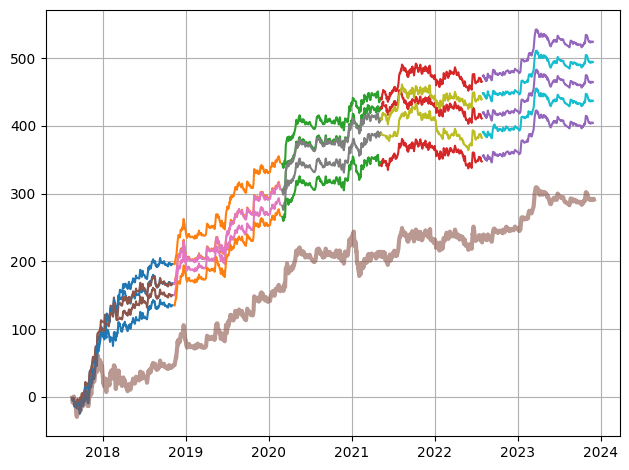

In [33]:
import sys
from experts import ExpertFormation, PyConfig
from backtest import backtest
from pathlib import Path
from dataloading import get_data, collect_train_data
import numpy as np
from loguru import logger
from tqdm import tqdm
import torch
from ml import train
import matplotlib.pyplot as plt
logger.remove()
logger.add(sys.stderr, level="INFO")



test_split_size = 0.2
device = "cuda"
cfg = PyConfig().test()
cfg.run_model_device = device

for _ in range(5):
    legend, last_prof = [], 0
    for i in range(int(1/test_split_size)):
        X_train, X_test, y_train, y_test, profs_train, profs_test, tf_test, test_dates = get_data(X, y, test_split_size, i, i+1)
        X_train = torch.tensor(X_train).float().to(device)
        model = train(X_train, y_train, None, None, batch_size=1024, epochs=30, device=device, calc_test=False)
        model.eval()
        X_train = X_train.float().to(device)
        p_train = model(X_train).detach().cpu().numpy().squeeze()[:, 0]    
        profsum_best, threshold = -999999, np.percentile(p_train, 20)
        # for th in np.arange(0., 0.9, 0.025):
        #     profsum = f1_score(y_train[:, 0], p_train>th)
        #     if profsum > profsum_best:
        #         profsum_best = profsum
        #         threshold = th
        model.set_threshold(threshold)
        torch.save(model.state_dict(), "model.pth")
        cfg.date_start=f"{test_dates[0][:4]}-{test_dates[0][4:6]}-{test_dates[0][6:]}"
        cfg.date_end=f"{test_dates[1][:4]}-{test_dates[1][4:6]}-{test_dates[1][6:]}"
        brok_results = backtest(cfg)
        cumsum = brok_results.profits.cumsum()
        print(brok_results.profits.sum(), threshold)
        plt.plot([pos.close_date for pos in brok_results.positions], cumsum + last_prof)
        last_prof += cumsum[-1]
        plt.grid("on")
        plt.tight_layout()
        legend.append(f"{test_dates[0]}-{test_dates[1]}")

cfg.run_model_device = None
cfg.date_start="2004-01-01"
cfg.date_end="2024-01-01"
brok_results = backtest(cfg)
print(brok_results.profits.sum())
plt.plot([pos.close_date for pos in brok_results.positions], brok_results.profits.cumsum(), linewidth=3, alpha=0.6)
legend.append("baseline")
# plt.legend(legend)
plt.savefig("backtest.png")
# plt.show()



In [6]:
import torch
from ml import Net
device = "cuda"
model = Net(7, 64)
model.load_state_dict(torch.load("model.pth"))
model.eval()
model.to(device)

RuntimeError: Error(s) in loading state_dict for Net:
	size mismatch for f.0.weight: copying a param with shape torch.Size([4, 1, 4, 3]) from checkpoint, the shape in current model is torch.Size([4, 1, 7, 3]).
	size mismatch for f.4.weight: copying a param with shape torch.Size([8, 4, 4, 3]) from checkpoint, the shape in current model is torch.Size([8, 4, 7, 3]).
	size mismatch for f.8.weight: copying a param with shape torch.Size([16, 8, 4, 3]) from checkpoint, the shape in current model is torch.Size([16, 8, 7, 3]).
	size mismatch for f.12.weight: copying a param with shape torch.Size([32, 16, 4, 3]) from checkpoint, the shape in current model is torch.Size([32, 16, 7, 3]).
	size mismatch for conv_valid.weight: copying a param with shape torch.Size([64, 32, 4, 4]) from checkpoint, the shape in current model is torch.Size([64, 32, 7, 4]).

In [ ]:
p = model.forward_thresholded(X_test)[:, 0]
w_profs_test = calc_weights(p_test[0], threshold)
pprofs_test = (profs_test*w_profs_test).sum(0)
pprofs_test, profs_test.sum()

In [ ]:
pprofs_sum1 = np.nansum(pprofits, 1)
gprofs_sum1 = np.nansum(gprofits, 1)
pprofs_sum1, gprofs_sum1, (pprofs_sum1-gprofs_sum1)/abs(gprofs_sum1)

In [ ]:
plt.plot(np.array(table)[:, 3], ".-")

In [ ]:
p_train.mean(), threshold

In [ ]:
import torch
from ml import Net
device = "cuda"
model = Net(7, 32)
model.load_state_dict(torch.load("model.pth"))
model.eval()
# model.set_threshold(-6)
model.to(device)
X_train, X_test, y_train, y_test, profs_train, profs_test, tf_test = get_data(X, y, test_split=1)
p_test = model(torch.tensor(X_test).float().to(device)).squeeze()
# profs_test.sum(), (profs_test*p_test).sum()
p_test

In [ ]:
X_train.shape

In [ ]:
list(model.named_parameters())[0]

In [ ]:
plt.plot(model(torch.tensor(X_test).float().to(device)).squeeze().detach().cpu().numpy())

In [ ]:
threshold

In [ ]:
y_test.sum(), (p_test>threshold).sum(), p_test.shape[0], y_test.shape[0]

In [ ]:
import mplfinance as mpf

ticker = "BTCUSDT"
tf = "H1"
hist_pd, hist = DataParser(
    EasyDict(
        date_start="2008-01-01",
        period=tf,
        ticker=ticker,
        data_type="bitfinex"
        )).load()

for i in ids_test:
    pos = poslist[i]
    if pos.ticker == ticker:
        prediction = model.predict_proba([X[i, :-1]])[0][1]
        if prediction < threshold:
            print(pos.ticker, pos.open_date, prediction)
            d2 = pd.to_datetime(pos.close_date)
            d1 = pd.to_datetime(pos.open_date)
            d0 = d1 - pd.DateOffset(days=3)
            hist2plot = hist_pd.loc[d0:d2]
            fig = mpf.plot(hist2plot, 
                type='candle', 
                block=False)

In [ ]:
prediction